<a href="https://colab.research.google.com/github/karthikstar/MLDA_Team-67_yeap-can/blob/main/MLDA_Team_yeap_can.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MLDA Team 67 - Pneumonia Detection Via Chest X-Ray Images
As COVID-19 becomes endemic, the strain on healthcare services worldwide intensifies, making it more difficult to manage & detect the serious complications of COVID-19

Creating a machine learning model with normal pneumonia x-ray datasets that could potentially be trained to find cases of COVID-19 pneumonia instead

We will be doing transfer learning using a pre-trained  Model known as InceptionV3. 




## Testing for GPU 


In [1]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


## Downloading the data

The dataset of chest x-ray iamges is on https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia . 

In [2]:
!pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list


ref                                                         title                                              size  lastUpdated          downloadCount  
----------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  
gpreda/reddit-vaccine-myths                                 Reddit Vaccine Myths                              235KB  2021-10-10 17:55:57          13776  
crowww/a-large-scale-fish-dataset                           A Large Scale Fish Dataset                          3GB  2021-04-28 17:03:01           8282  
imsparsh/musicnet-dataset                                   MusicNet Dataset                                   22GB  2021-02-18 14:12:19           3688  
fatiimaezzahra/famous-iconic-women                          Famous Iconic Women                               838MB  2021-02-28 14:56:00           1597  
dhruvildave/wikibooks-dataset                               Wikibooks Datase

In [3]:
! kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [00:26<00:00, 47.3MB/s]
100% 2.29G/2.29G [00:26<00:00, 92.3MB/s]


In [4]:
!unzip -qq chest-xray-pneumonia.zip
!rm chest-xray-pneumonia.zip

In [5]:
!wget -qq https://www.dropbox.com/s/vj61417lofjebju/utils.zip
!unzip -qq utils.zip
!rm utils.zip

In [6]:
!ls

chest_xray  gdrive.py  kaggle.json  __MACOSX  sample_data  sutils.py


In [6]:
%matplotlib inline
import matplotlib.pyplot as plt


from sutils import *
import os, json
from glob import glob
import numpy as np

from tensorflow.keras import optimizers

from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.vgg16 import VGG16


from tensorflow.python.keras.preprocessing import image
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator

from tensorflow.python.keras.models import Model,load_model,Sequential

from tensorflow.python.keras.layers import Dense, GlobalAveragePooling2D, Dropout,Flatten, Input, Conv2D, MaxPooling2D, Dropout, Flatten
from tensorflow.python.keras import backend as K

from tensorflow.keras.callbacks import ModelCheckpoint, Callback




In [7]:
print(tf.__version__)
print(tf.keras.__version__)


2.6.0
2.6.0


In [8]:


!ls chest_xray/

chest_xray  __MACOSX  test  train  val


In [9]:
!ls chest_xray/test/NORMAL/

IM-0001-0001.jpeg	   NORMAL2-IM-0173-0001-0001.jpeg
IM-0003-0001.jpeg	   NORMAL2-IM-0173-0001-0002.jpeg
IM-0005-0001.jpeg	   NORMAL2-IM-0195-0001.jpeg
IM-0006-0001.jpeg	   NORMAL2-IM-0196-0001.jpeg
IM-0007-0001.jpeg	   NORMAL2-IM-0198-0001.jpeg
IM-0009-0001.jpeg	   NORMAL2-IM-0199-0001.jpeg
IM-0010-0001.jpeg	   NORMAL2-IM-0201-0001.jpeg
IM-0011-0001-0001.jpeg	   NORMAL2-IM-0206-0001.jpeg
IM-0011-0001-0002.jpeg	   NORMAL2-IM-0207-0001.jpeg
IM-0011-0001.jpeg	   NORMAL2-IM-0210-0001.jpeg
IM-0013-0001.jpeg	   NORMAL2-IM-0213-0001.jpeg
IM-0015-0001.jpeg	   NORMAL2-IM-0217-0001.jpeg
IM-0016-0001.jpeg	   NORMAL2-IM-0219-0001.jpeg
IM-0017-0001.jpeg	   NORMAL2-IM-0221-0001.jpeg
IM-0019-0001.jpeg	   NORMAL2-IM-0222-0001.jpeg
IM-0021-0001.jpeg	   NORMAL2-IM-0229-0001.jpeg
IM-0022-0001.jpeg	   NORMAL2-IM-0232-0001.jpeg
IM-0023-0001.jpeg	   NORMAL2-IM-0233-0001.jpeg
IM-0025-0001.jpeg	   NORMAL2-IM-0237-0001.jpeg
IM-0027-0001.jpeg	   NORMAL2-IM-0238-0001.jpeg
IM-0028-0001.jpeg	   NORMAL2-IM-0241-000

In [10]:
# Set up some Hyperparameters

batch_size = 32
epochs = 10

lr = 0.001

## Converting raw files in folders into something we can feed into tf.data

We use glob to get lists of the files in the directories and then convert them into dataframes and add in class numbers.



In [11]:
import glob
import pandas as pd

filenames_test_normal = glob.glob('./chest_xray/test/NORMAL/*.jpeg')
filenames_test_pneumonia = glob.glob('./chest_xray/test/PNEUMONIA/*.jpeg')
filenames_train_normal = glob.glob('./chest_xray/train/NORMAL/*.jpeg')
filenames_train_pneumonia = glob.glob('./chest_xray/train/PNEUMONIA/*.jpeg')
filenames_val_normal = glob.glob('./chest_xray/val/NORMAL/*.jpeg')
filenames_val_pneumonia = glob.glob('./chest_xray/val/PNEUMONIA/*.jpeg')


In [12]:
print('Test Dataset - Normal:', len(filenames_test_normal))
print('Test Dataset - Pneumonia:', len(filenames_test_pneumonia))
print('Test Dataset Total:', len(filenames_test_pneumonia) + len(filenames_test_normal))

print('Train Dataset - Normal:', len(filenames_train_normal))
print('Train Dataset - Pneumonia:', len(filenames_train_pneumonia))

print('Train Dataset Total:', len(filenames_train_pneumonia) + len(filenames_train_normal))

print('Val Dataset - Normal:', len(filenames_val_normal))
print('Val Dataset - Pneumonia:', len(filenames_val_pneumonia))
print('Val Dataset Total:', len(filenames_val_pneumonia) + len(filenames_val_normal))

print('Normal Data:',len(filenames_test_normal)+len(filenames_train_normal)+len(filenames_val_normal),'Pneumonia:',len(filenames_test_pneumonia)+len(filenames_train_pneumonia)+len(filenames_val_normal))

Test Dataset - Normal: 234
Test Dataset - Pneumonia: 390
Test Dataset Total: 624
Train Dataset - Normal: 1341
Train Dataset - Pneumonia: 3875
Train Dataset Total: 5216
Val Dataset - Normal: 8
Val Dataset - Pneumonia: 8
Val Dataset Total: 16
Normal Data: 1583 Pneumonia: 4273


In [13]:
filenames_test_normal[:10]

['./chest_xray/test/NORMAL/IM-0011-0001.jpeg',
 './chest_xray/test/NORMAL/NORMAL2-IM-0309-0001.jpeg',
 './chest_xray/test/NORMAL/IM-0067-0001.jpeg',
 './chest_xray/test/NORMAL/NORMAL2-IM-0237-0001.jpeg',
 './chest_xray/test/NORMAL/IM-0017-0001.jpeg',
 './chest_xray/test/NORMAL/NORMAL2-IM-0238-0001.jpeg',
 './chest_xray/test/NORMAL/NORMAL2-IM-0210-0001.jpeg',
 './chest_xray/test/NORMAL/NORMAL2-IM-0305-0001.jpeg',
 './chest_xray/test/NORMAL/NORMAL2-IM-0201-0001.jpeg',
 './chest_xray/test/NORMAL/NORMAL2-IM-0199-0001.jpeg']

The pre-allocated number of images for Train,Validation and Test datasets are not ideal hence we are going to do the below to get a 70 20 10 split.



In [14]:
df_train_normal = pd.DataFrame(filenames_train_normal, columns=["filename"])
df_train_pneumonia = pd.DataFrame(filenames_train_pneumonia, columns=["filename"])

df_val_normal = pd.DataFrame(filenames_val_normal, columns=["filename"])
df_val_pneumonia = pd.DataFrame(filenames_val_pneumonia, columns=["filename"])

df_test_normal = pd.DataFrame(filenames_test_normal, columns=["filename"])
df_test_pneumonia = pd.DataFrame(filenames_test_pneumonia, columns=["filename"])

df_train_normal.head()

# 0 represents NORMAL , 1 represents PNEUMONIA

# Add Class column to represent normal(0) and pneumonia (1)

df_train_normal['class'] = pd.Series([0 for x in range(len(df_train_normal.index))], index=df_train_normal.index)
df_train_pneumonia['class'] = pd.Series([1 for x in range(len(df_train_pneumonia.index))], index=df_train_pneumonia.index)
df_val_normal['class'] = pd.Series([0 for x in range(len(df_val_normal.index))], index=df_val_normal.index)
df_val_pneumonia['class'] = pd.Series([1 for x in range(len(df_val_pneumonia.index))], index=df_val_pneumonia.index)
df_test_normal['class'] = pd.Series([0 for x in range(len(df_test_normal.index))], index=df_test_normal.index)
df_test_pneumonia['class'] = pd.Series([1 for x in range(len(df_test_pneumonia.index))], index=df_test_pneumonia.index)

df_train_normal.head()

,filename,class
0,./chest_xray/train/NORMAL/NORMAL2-IM-1401-0001...,0
1,./chest_xray/train/NORMAL/IM-0665-0001.jpeg,0
2,./chest_xray/train/NORMAL/NORMAL2-IM-1218-0001...,0
3,./chest_xray/train/NORMAL/IM-0399-0001.jpeg,0
4,./chest_xray/train/NORMAL/IM-0435-0001.jpeg,0


In [15]:
print(df_train_normal.head())
print(df_train_pneumonia.head())
print(df_val_normal.head())
print(df_val_pneumonia.head())
print(df_test_normal.head())
print(df_test_pneumonia.head())


                                            filename  class
0  ./chest_xray/train/NORMAL/NORMAL2-IM-1401-0001...      0
1        ./chest_xray/train/NORMAL/IM-0665-0001.jpeg      0
2  ./chest_xray/train/NORMAL/NORMAL2-IM-1218-0001...      0
3        ./chest_xray/train/NORMAL/IM-0399-0001.jpeg      0
4        ./chest_xray/train/NORMAL/IM-0435-0001.jpeg      0
                                            filename  class
0  ./chest_xray/train/PNEUMONIA/person348_virus_7...      1
1  ./chest_xray/train/PNEUMONIA/person486_bacteri...      1
2  ./chest_xray/train/PNEUMONIA/person1732_bacter...      1
3  ./chest_xray/train/PNEUMONIA/person1275_bacter...      1
4  ./chest_xray/train/PNEUMONIA/person1670_bacter...      1
                                            filename  class
0  ./chest_xray/val/NORMAL/NORMAL2-IM-1440-0001.jpeg      0
1  ./chest_xray/val/NORMAL/NORMAL2-IM-1436-0001.jpeg      0
2  ./chest_xray/val/NORMAL/NORMAL2-IM-1437-0001.jpeg      0
3  ./chest_xray/val/NORMAL/NORMAL2-IM-14

In [16]:
# Split into train and validation sets
train_set_percentage = .7
val_set_percentage = .9
test_set_percentage = 1


train_df = df_train_normal[:int(len(df_train_normal)*train_set_percentage)]
val_df = df_train_normal[int(len(df_train_normal)*train_set_percentage):int(len(df_train_normal)*val_set_percentage)]
test_df = df_train_normal[int(len(df_train_normal)*val_set_percentage):]

train_df2 = df_train_pneumonia[:int(len(df_train_pneumonia)*train_set_percentage)]
val_df2 = df_train_pneumonia[int(len(df_train_pneumonia)*train_set_percentage):int(len(df_train_pneumonia)*val_set_percentage)]
test_df2 = df_train_pneumonia[int(len(df_train_pneumonia)*val_set_percentage):]


train_df3 = df_val_normal[:int(len(df_val_normal)*train_set_percentage)]
val_df3 = df_val_normal[int(len(df_val_normal)*train_set_percentage):int(len(df_val_normal)*val_set_percentage)]
test_df3 = df_val_normal[int(len(df_val_normal)*val_set_percentage):]

train_df4 = df_val_pneumonia[:int(len(df_val_pneumonia)*train_set_percentage)]
val_df4 = df_val_pneumonia[int(len(df_val_pneumonia)*train_set_percentage):int(len(df_val_pneumonia)*val_set_percentage)]
test_df4 = df_val_pneumonia[int(len(df_val_pneumonia)*val_set_percentage):]

train_df5 = df_test_normal[:int(len(df_test_normal)*train_set_percentage)]
val_df5 = df_test_normal[int(len(df_test_normal)*train_set_percentage):int(len(df_test_normal)*val_set_percentage)]
test_df5 = df_test_normal[int(len(df_test_normal)*val_set_percentage):]


train_df6 = df_test_pneumonia[:int(len(df_test_pneumonia)*train_set_percentage)]
val_df6 = df_test_pneumonia[int(len(df_test_pneumonia)*train_set_percentage):int(len(df_test_pneumonia)*val_set_percentage)]
test_df6 = df_test_pneumonia[int(len(df_test_pneumonia)*val_set_percentage):]



df_new_train = pd.concat([train_df, train_df2, train_df3, train_df4, train_df5,train_df6])
df_new_val = pd.concat([val_df, val_df2, val_df3, val_df4, val_df5,val_df6])
df_new_test = pd.concat([test_df, test_df2, test_df3, test_df4, test_df5, test_df6])


# Shuffle
df = df_new_train.sample(frac=1).reset_index(drop=True)
df_val = df_new_val.sample(frac=1).reset_index(drop=True)
df_test = df_new_test.sample(frac=1).reset_index(drop=True)

# Examine the Dataset

lets look at what we have now. 

In [17]:
df.head()

,filename,class
0,./chest_xray/train/PNEUMONIA/person598_virus_1...,1
1,./chest_xray/train/PNEUMONIA/person531_bacteri...,1
2,./chest_xray/train/NORMAL/NORMAL2-IM-0603-0001...,0
3,./chest_xray/test/PNEUMONIA/person111_bacteria...,1
4,./chest_xray/train/PNEUMONIA/person635_bacteri...,1


In [18]:
df_val.head()

,filename,class
0,./chest_xray/train/NORMAL/NORMAL2-IM-1098-0001...,0
1,./chest_xray/train/PNEUMONIA/person142_virus_2...,1
2,./chest_xray/train/NORMAL/NORMAL2-IM-0906-0001...,0
3,./chest_xray/train/PNEUMONIA/person1239_virus_...,1
4,./chest_xray/test/NORMAL/NORMAL2-IM-0326-0001....,0


In [19]:
df_test.head()

,filename,class
0,./chest_xray/train/PNEUMONIA/person732_bacteri...,1
1,./chest_xray/train/PNEUMONIA/person67_bacteria...,1
2,./chest_xray/train/PNEUMONIA/person421_bacteri...,1
3,./chest_xray/train/NORMAL/IM-0636-0001.jpeg,0
4,./chest_xray/train/PNEUMONIA/person61_bacteria...,1


In [20]:
print(df.shape)
print(df_val.shape)
print(df_test.shape)

df['class'].unique()

#4096 test data, 1172 validation data, test data.

(4096, 2)
(1172, 2)
(588, 2)


array([1, 0])

In [24]:
print('Train data:')
print(df['class'].value_counts())
print('Val data:')
print(df_val['class'].value_counts())
print('Test data:')
print(df_test['class'].value_counts())


Train data:
1    2990
0    1106
Name: class, dtype: int64
Val data:
1    855
0    317
Name: class, dtype: int64
Test data:
1    428
0    160
Name: class, dtype: int64


1    2990
0    1106
Name: class, dtype: int64


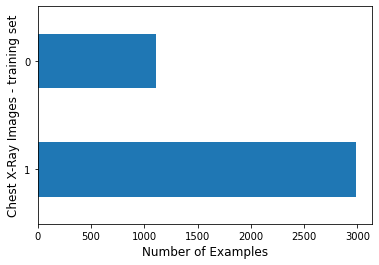

In [25]:
print(df['class'].value_counts())


ax = df['class'].value_counts().plot.barh()
ax.set_xlabel("Number of Examples", fontsize=12)
ax.set_ylabel("Chest X-Ray Images - training set", fontsize=12)
# ax.set_yticklabels(['Dandelions','Tulips','Roses','Daisies','Sunflower'], rotation=0, fontsize=12)
from matplotlib import pyplot as plt

plt.show()

As we can see, the training set has more pneumonia positive data than normal data.This was expected since originally the dataset had a total of 1583 normal data and 4273 pneumonia positive data. Nevertheless, we believe that the quantity for both positive pneumonia and normal pneumonia is sufficient enough to proceed and having more positive pneumonia data might help to increase the accuracy of the model. 


In [26]:
# convert the dataframe into 2 lists to use for filename and labels
train_filenames_list = df["filename"].tolist()
train_labels_list = df["class"].astype('int32').tolist()

# convert the dataframe into 2 lists to use for filename and labels
val_filenames_list = df_val["filename"].tolist()
val_labels_list = df_val["class"].astype('int32').tolist()

# convert the dataframe into 2 lists to use for filename and labels
test_filenames_list = df_test["filename"].tolist()
test_labels_list = df_test["class"].astype('int32').tolist()


#number of classes
num_classes = 2



## Make the pipeline for loading and resizing the images

In [27]:
# Reads an image from a file, decodes it into a tensor, and resizes it
# to a fixed shape.
img_rows, img_cols = 299,299

def _parse_function(filename, label):
  image_string = tf.io.read_file(filename)
  image_decoded = tf.image.decode_jpeg(image_string,channels=3)
  image_resized = tf.image.resize(image_decoded, [img_rows, img_cols])
  label = tf.one_hot(label, num_classes)
  return image_resized, label

In [28]:
# A vector of filenames - from a list
filenames = tf.constant(train_filenames_list)

# Labels that match the training files - from a list
labels = tf.constant(train_labels_list)

# Same as above but for validation set
val_filenames = tf.constant(val_filenames_list)
val_labels = tf.constant(val_labels_list)

# Same as above but for test set
test_filenames = tf.constant(test_filenames_list)
test_labels = tf.constant(test_labels_list)


## Assembling the Data pipeline using tf.data

In [29]:
train_dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
train_dataset = train_dataset.map(_parse_function)
train_dataset = train_dataset.repeat(100)
train_dataset = train_dataset.batch(32)

In [30]:
valid_dataset = tf.data.Dataset.from_tensor_slices((val_filenames, val_labels))
valid_dataset = valid_dataset.map(_parse_function)
valid_dataset = valid_dataset.repeat(100)
valid_dataset = valid_dataset.batch(32)

In [31]:
test_dataset = tf.data.Dataset.from_tensor_slices((test_filenames, test_labels))
test_dataset = test_dataset.map(_parse_function)
test_dataset = test_dataset.repeat(100)
test_dataset = test_dataset.batch(32)

## Chosing the pre-trained network for Transfer Learning



We are going to be using InceptionV3 as it has the combination of 2 parameters that we are looking out for, good accuracy and low parameters, to ensure that this model remains lightweight while being able to give a good accuracy, so that it will be feasible to deploy at healthcare instituitions for instance.

Image Reference: https://www.google.com/url?sa=i&url=https%3A%2F%2Ftowardsdatascience.com%2Fillustrated-10-cnn-architectures-95d78ace614d&psig=AOvVaw1flc8yaYq0La5kz0Q5b-dy&ust=1609747201351000&source=images&cd=vfe&ved=0CA0QjhxqFwoTCIC_sc-k_-0CFQAAAAAdAAAAABAI

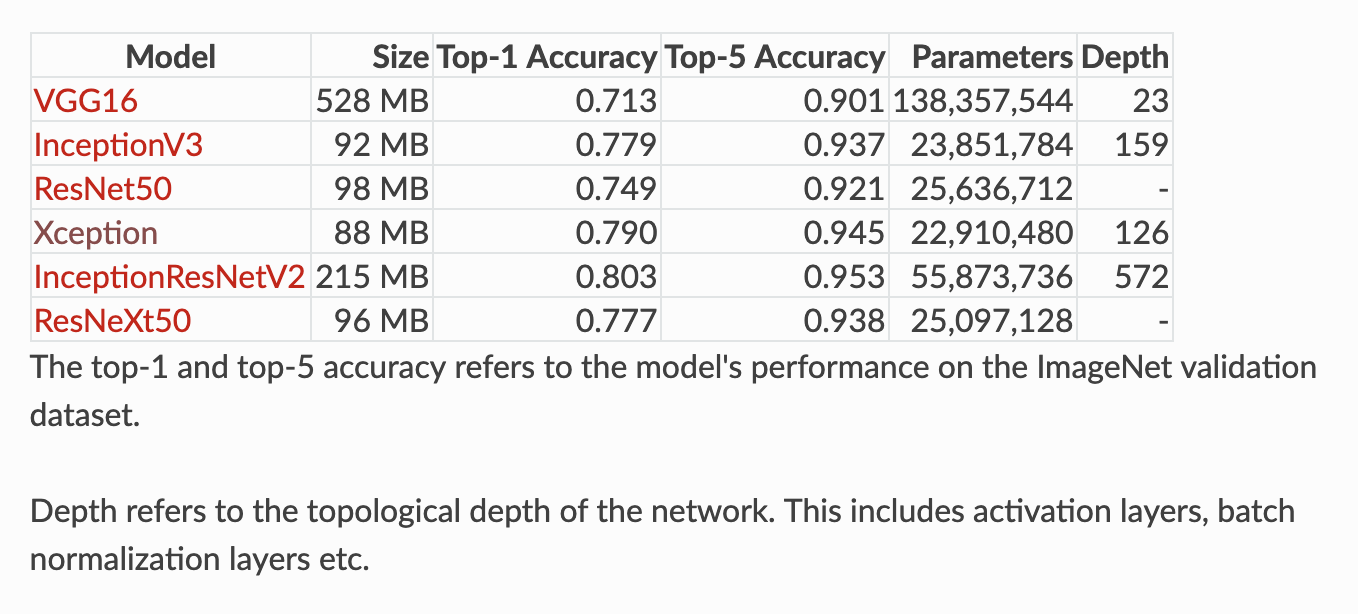

In [33]:
# InceptionV3 Model - trained on image net
# base_model = InceptionV3(weights='imagenet', include_top=False)
base_model = tf.keras.applications.inception_v3.InceptionV3(
    include_top=True, weights='imagenet', input_tensor=None,
    input_shape=None, pooling=None, classes=1000,
    classifier_activation='softmax'
)
# VGG16 Model - trained on image net
#base_model = VGG16(weights='imagenet', include_top=False)


96124928/96112376 [==============================] - 1s 0us/step


In [34]:
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

## Create a simple head for the model that we can train

In [49]:
x = base_model.output

# let's add a fully-connected layer
x = tf.keras.layers.Dense(1024, activation='relu')(x)


# 2 Classes for flowers
predictions = tf.keras.layers.Dense(num_classes, activation='softmax')(x)


In [51]:
# Creating the model that we will train
model = tf.keras.Model(inputs=base_model.input, outputs=predictions)

In [52]:
# Freeze the InceptionV3 layers except the BatchNorm
for layer in base_model.layers:
    if 'batch' in layer.name:
      print(layer.name)
      layer.trainable = True
    else:
      layer.trainable = False 


batch_normalization
batch_normalization_1
batch_normalization_2
batch_normalization_3
batch_normalization_4
batch_normalization_8
batch_normalization_6
batch_normalization_9
batch_normalization_5
batch_normalization_7
batch_normalization_10
batch_normalization_11
batch_normalization_15
batch_normalization_13
batch_normalization_16
batch_normalization_12
batch_normalization_14
batch_normalization_17
batch_normalization_18
batch_normalization_22
batch_normalization_20
batch_normalization_23
batch_normalization_19
batch_normalization_21
batch_normalization_24
batch_normalization_25
batch_normalization_27
batch_normalization_28
batch_normalization_26
batch_normalization_29
batch_normalization_34
batch_normalization_35
batch_normalization_31
batch_normalization_36
batch_normalization_32
batch_normalization_37
batch_normalization_30
batch_normalization_33
batch_normalization_38
batch_normalization_39
batch_normalization_44
batch_normalization_45
batch_normalization_41
batch_normalization_46


In [53]:
for layer in model.layers:
    print(layer.name)
    print(layer.trainable)

input_1
False
conv2d
False
batch_normalization
True
activation
False
conv2d_1
False
batch_normalization_1
True
activation_1
False
conv2d_2
False
batch_normalization_2
True
activation_2
False
max_pooling2d
False
conv2d_3
False
batch_normalization_3
True
activation_3
False
conv2d_4
False
batch_normalization_4
True
activation_4
False
max_pooling2d_1
False
conv2d_8
False
batch_normalization_8
True
activation_8
False
conv2d_6
False
conv2d_9
False
batch_normalization_6
True
batch_normalization_9
True
activation_6
False
activation_9
False
average_pooling2d
False
conv2d_5
False
conv2d_7
False
conv2d_10
False
conv2d_11
False
batch_normalization_5
True
batch_normalization_7
True
batch_normalization_10
True
batch_normalization_11
True
activation_5
False
activation_7
False
activation_10
False
activation_11
False
mixed0
False
conv2d_15
False
batch_normalization_15
True
activation_15
False
conv2d_13
False
conv2d_16
False
batch_normalization_13
True
batch_normalization_16
True
activation_13
False
act

## Select an Optimizer 

In [55]:
# creates the optimizer using a tensorFlow optimizer with lr setting the Learning Rate

# tf.keras optimizer
opt = tf.keras.optimizers.Adam(lr)

# We could use a TensorFlow Optimizer but they can't save the weight as a whole
# opt = tf.train.AdamOptimizer(lr)

## Compile the model

In [56]:
# compile the model 

model.compile(optimizer= opt, loss='categorical_crossentropy',metrics=['accuracy'])

## Call backs

In [57]:
!mkdir checkpoints


In [60]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('./checkpoints/best_weights.hdf5', verbose=1, save_best_only=True, mode='auto')

In [61]:
batch_size


32

In [63]:
train_steps = int(4096/batch_size) #training data / batch size = 4096 / 32 = 128
val_steps = 50
epochs = 5
# train_steps

128

## Fit the model

we pass in:
- The training set
- the steps for how many times we want to sample a batch to be one epoch
- number of epochs
- validation set
- number of steps for validation

In [64]:
# # Train the model with validation 
history = model.fit( train_dataset, steps_per_epoch = train_steps,
                   epochs = epochs,
                   validation_data = valid_dataset,
                   validation_steps = val_steps,
                   callbacks=[checkpoint])

Epoch 1/5
128/128 [==============================] - 172s 1s/step - loss: 0.3815 - accuracy: 0.8254 - val_loss: 0.2209 - val_accuracy: 0.9019

Epoch 00001: val_loss improved from inf to 0.22088, saving model to ./checkpoints/best_weights.hdf5
Epoch 2/5
128/128 [==============================] - 130s 1s/step - loss: 0.1641 - accuracy: 0.9358 - val_loss: 0.1616 - val_accuracy: 0.9438

Epoch 00002: val_loss improved from 0.22088 to 0.16164, saving model to ./checkpoints/best_weights.hdf5
Epoch 3/5
128/128 [==============================] - 129s 1s/step - loss: 0.1148 - accuracy: 0.9590 - val_loss: 0.1527 - val_accuracy: 0.9500

Epoch 00003: val_loss improved from 0.16164 to 0.15273, saving model to ./checkpoints/best_weights.hdf5
Epoch 4/5
128/128 [==============================] - 130s 1s/step - loss: 0.0829 - accuracy: 0.9736 - val_loss: 0.1574 - val_accuracy: 0.9488

Epoch 00004: val_loss did not improve from 0.15273
Epoch 5/5
128/128 [==============================] - 129s 1s/step - l

In [65]:
#Visualising model loss over epochs

def plot_train(hist):
    h = hist.history
    if 'acc' in h:
        meas='acc'
        loc='lower right'
    else:
        meas='loss'
        loc='upper right'
    plt.plot(hist.history[meas])
    plt.plot(hist.history['val_'+meas])
    plt.title('model '+meas)
    plt.ylabel(meas)
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc=loc)

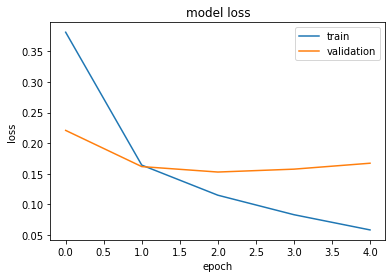

In [66]:
plot_train(history)

We are going to train the model for more epochs, with more callbacks added to optimise the training process.

In [67]:
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, ReduceLROnPlateau, LearningRateScheduler, EarlyStopping, TensorBoard
from tensorflow.keras.callbacks import LambdaCallback, CSVLogger

from tensorflow.keras import backend as K

reduce_LR = ReduceLROnPlateau(monitor='val_loss',factor = 0.9, patience=2,cooldown=1, min_lr = 0.00001) 

lr_print = LambdaCallback(on_epoch_begin=lambda epoch,logs: print("lr:",K.eval(model.optimizer.lr)))


In [68]:
# # Train the model with validation 
history = model.fit( train_dataset, steps_per_epoch = train_steps,
                   epochs = 30,
                   validation_data = valid_dataset,
                   validation_steps = val_steps,
                   callbacks=[checkpoint,lr_print,reduce_LR])

Epoch 1/30
lr: 0.001
128/128 [==============================] - 130s 1s/step - loss: 0.0383 - accuracy: 0.9907 - val_loss: 0.1856 - val_accuracy: 0.9469

Epoch 00001: val_loss did not improve from 0.15273
Epoch 2/30
lr: 0.001
128/128 [==============================] - 129s 1s/step - loss: 0.0240 - accuracy: 0.9956 - val_loss: 0.1996 - val_accuracy: 0.9475

Epoch 00002: val_loss did not improve from 0.15273
Epoch 3/30
lr: 0.001
128/128 [==============================] - 128s 1s/step - loss: 0.0156 - accuracy: 0.9973 - val_loss: 0.2075 - val_accuracy: 0.9525

Epoch 00003: val_loss did not improve from 0.15273
Epoch 4/30
lr: 0.00090000004
128/128 [==============================] - 129s 1s/step - loss: 0.0098 - accuracy: 0.9985 - val_loss: 0.2114 - val_accuracy: 0.9531

Epoch 00004: val_loss did not improve from 0.15273
Epoch 5/30
lr: 0.00090000004
128/128 [==============================] - 128s 1s/step - loss: 0.0061 - accuracy: 0.9993 - val_loss: 0.2289 - val_accuracy: 0.9513

Epoch 0000

KeyboardInterrupt: ignored

As we can see above, after running a further 14 epochs, model accuracy has not improved, and observing how the test accuracy is 1 while the validation accuracy has dropped over the epochs, it shows signs of overfitting. Thus, we interrupted the training as further training of the model doesn't improve its accuracy.

In future model training, we intend to introduce some image augmentation expand the training dataset in order to improve the performance and ability of the model to generalize.


Now, let's evaluate the model using the existing best weights that we have obtained.


In [69]:
!ls checkpoints

best_weights.hdf5


In [70]:
model.load_weights('./checkpoints/best_weights.hdf5')


In [71]:
metrics = model.evaluate(test_dataset,steps=50)
print("model accuracy:",metrics[1])

50/50 [==============================] - 22s 435ms/step - loss: 0.2032 - accuracy: 0.9394
model accuracy: 0.9393749833106995


We have determined that our model accuracy is 93.94%, based on the test dataset.

## Make some predictions


In [72]:
test_dataset

<BatchDataset shapes: ((None, 299, 299, 3), (None, 2)), types: (tf.float32, tf.float32)>

In [73]:
preds = model.predict(test_dataset,steps=10)
preds = preds.argmax(axis=-1)

preds.shape

(320,)

In [74]:
test_labels = test_labels_list[0:320]

In [75]:
len(test_labels)

320

## Make a Confusion Matrix


In [76]:
from sklearn.metrics import confusion_matrix
import itertools

cm = confusion_matrix(test_labels,preds)

In [77]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')



Normalized confusion matrix
[[0.92771084 0.07228916]
 [0.03375527 0.96624473]]


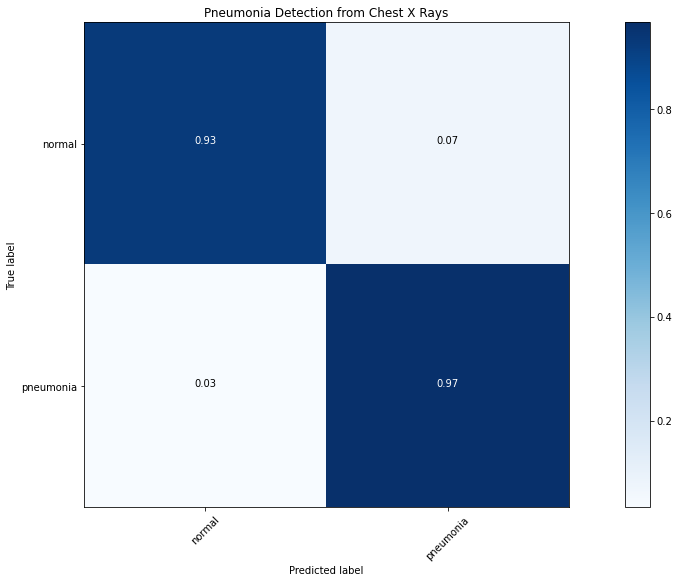

In [79]:
cm_plot_labels = ['normal','pneumonia']
import numpy as np


# # Plot normalized confusion matrix
plt.figure(figsize=(16,8))
plot_confusion_matrix(cm, cm_plot_labels, normalize=True,
                      title='Pneumonia Detection from Chest X Rays')

plt.show()

As we can see here, the model has a 93% accuracy when predicting a true normal x ray wheras it has 97% accuracy when predicting a true pneumonic x-ray. The lower percentage for true normal x ray could be attributed to the fact that there is a smaller training dataset available for normal x-rays as compared to pneumonic ones.



## Save the Model and weights 

In [80]:
model.save('pneumoniadetection.h5')


In [81]:
model.save_weights('pneumonia_weights_v1.h5', save_format='h5')

In [82]:
!ls

checkpoints  kaggle.json	    pneumonia_weights_v1.h5
chest_xray   __MACOSX		    sample_data
gdrive.py    pneumoniadetection.h5  sutils.py


In [ ]:
# model = load_model('pneumoniadetection.h5')

## Make some predictions

We will upload a chest x-ray iamge which is pneumonia positive and see what the model predicts.

In [84]:
!ls chest_xray/test

NORMAL	PNEUMONIA


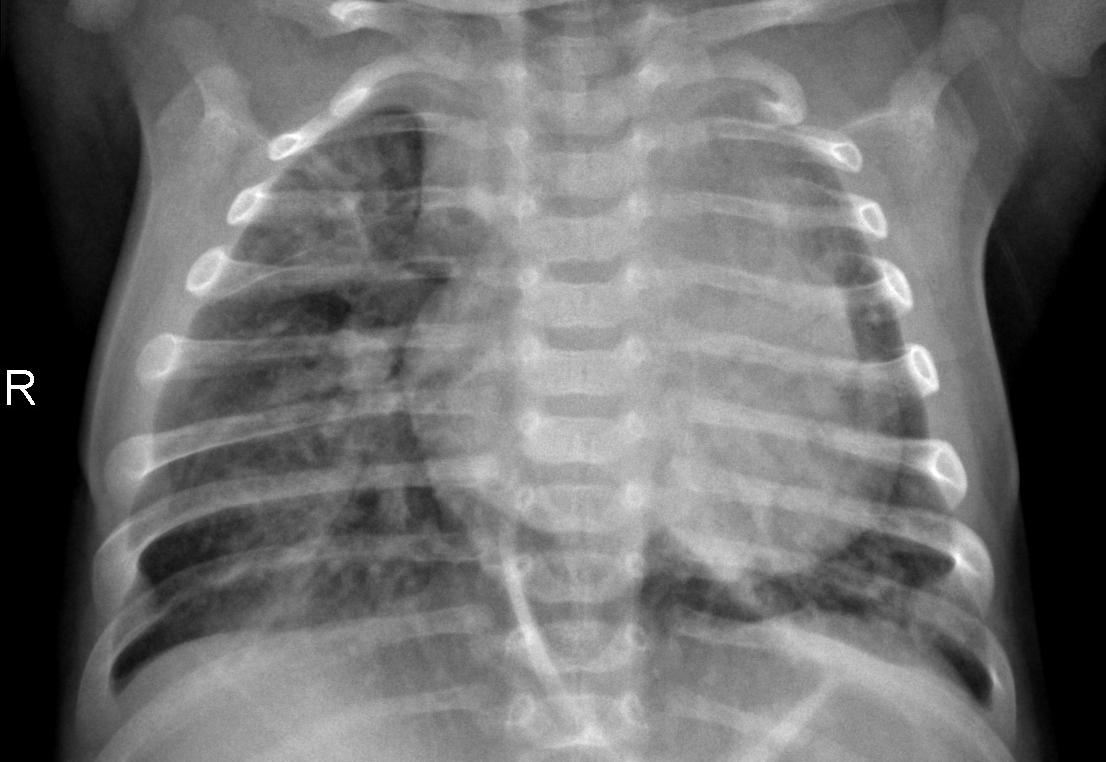

In [85]:
from IPython.display import Image

Image('./chest_xray/test/PNEUMONIA/person100_bacteria_475.jpeg',width=800)

In [86]:
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input, decode_predictions
import numpy as np

img_path = './chest_xray/test/PNEUMONIA/person100_bacteria_475.jpeg'
img = image.load_img(img_path, target_size=(299, 299))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
# x = preprocess_input(x)
print('Input image shape:', x.shape)

Input image shape: (1, 299, 299, 3)


In [87]:
pred = model.predict(x)
print('Predicted:', pred)

print(np.argmax(pred))

Predicted: [[0.04089437 0.9591056 ]]
1


In [88]:
result= np.argmax(pred)
if result==0:
    print("Normal")
elif result==1:
    print("Pneumonia Detected ")


Pneumonia Detected 


Pnuemonia is indeed present in the chest xray scan above.

Let's try another chest-ray which is NORMAL.

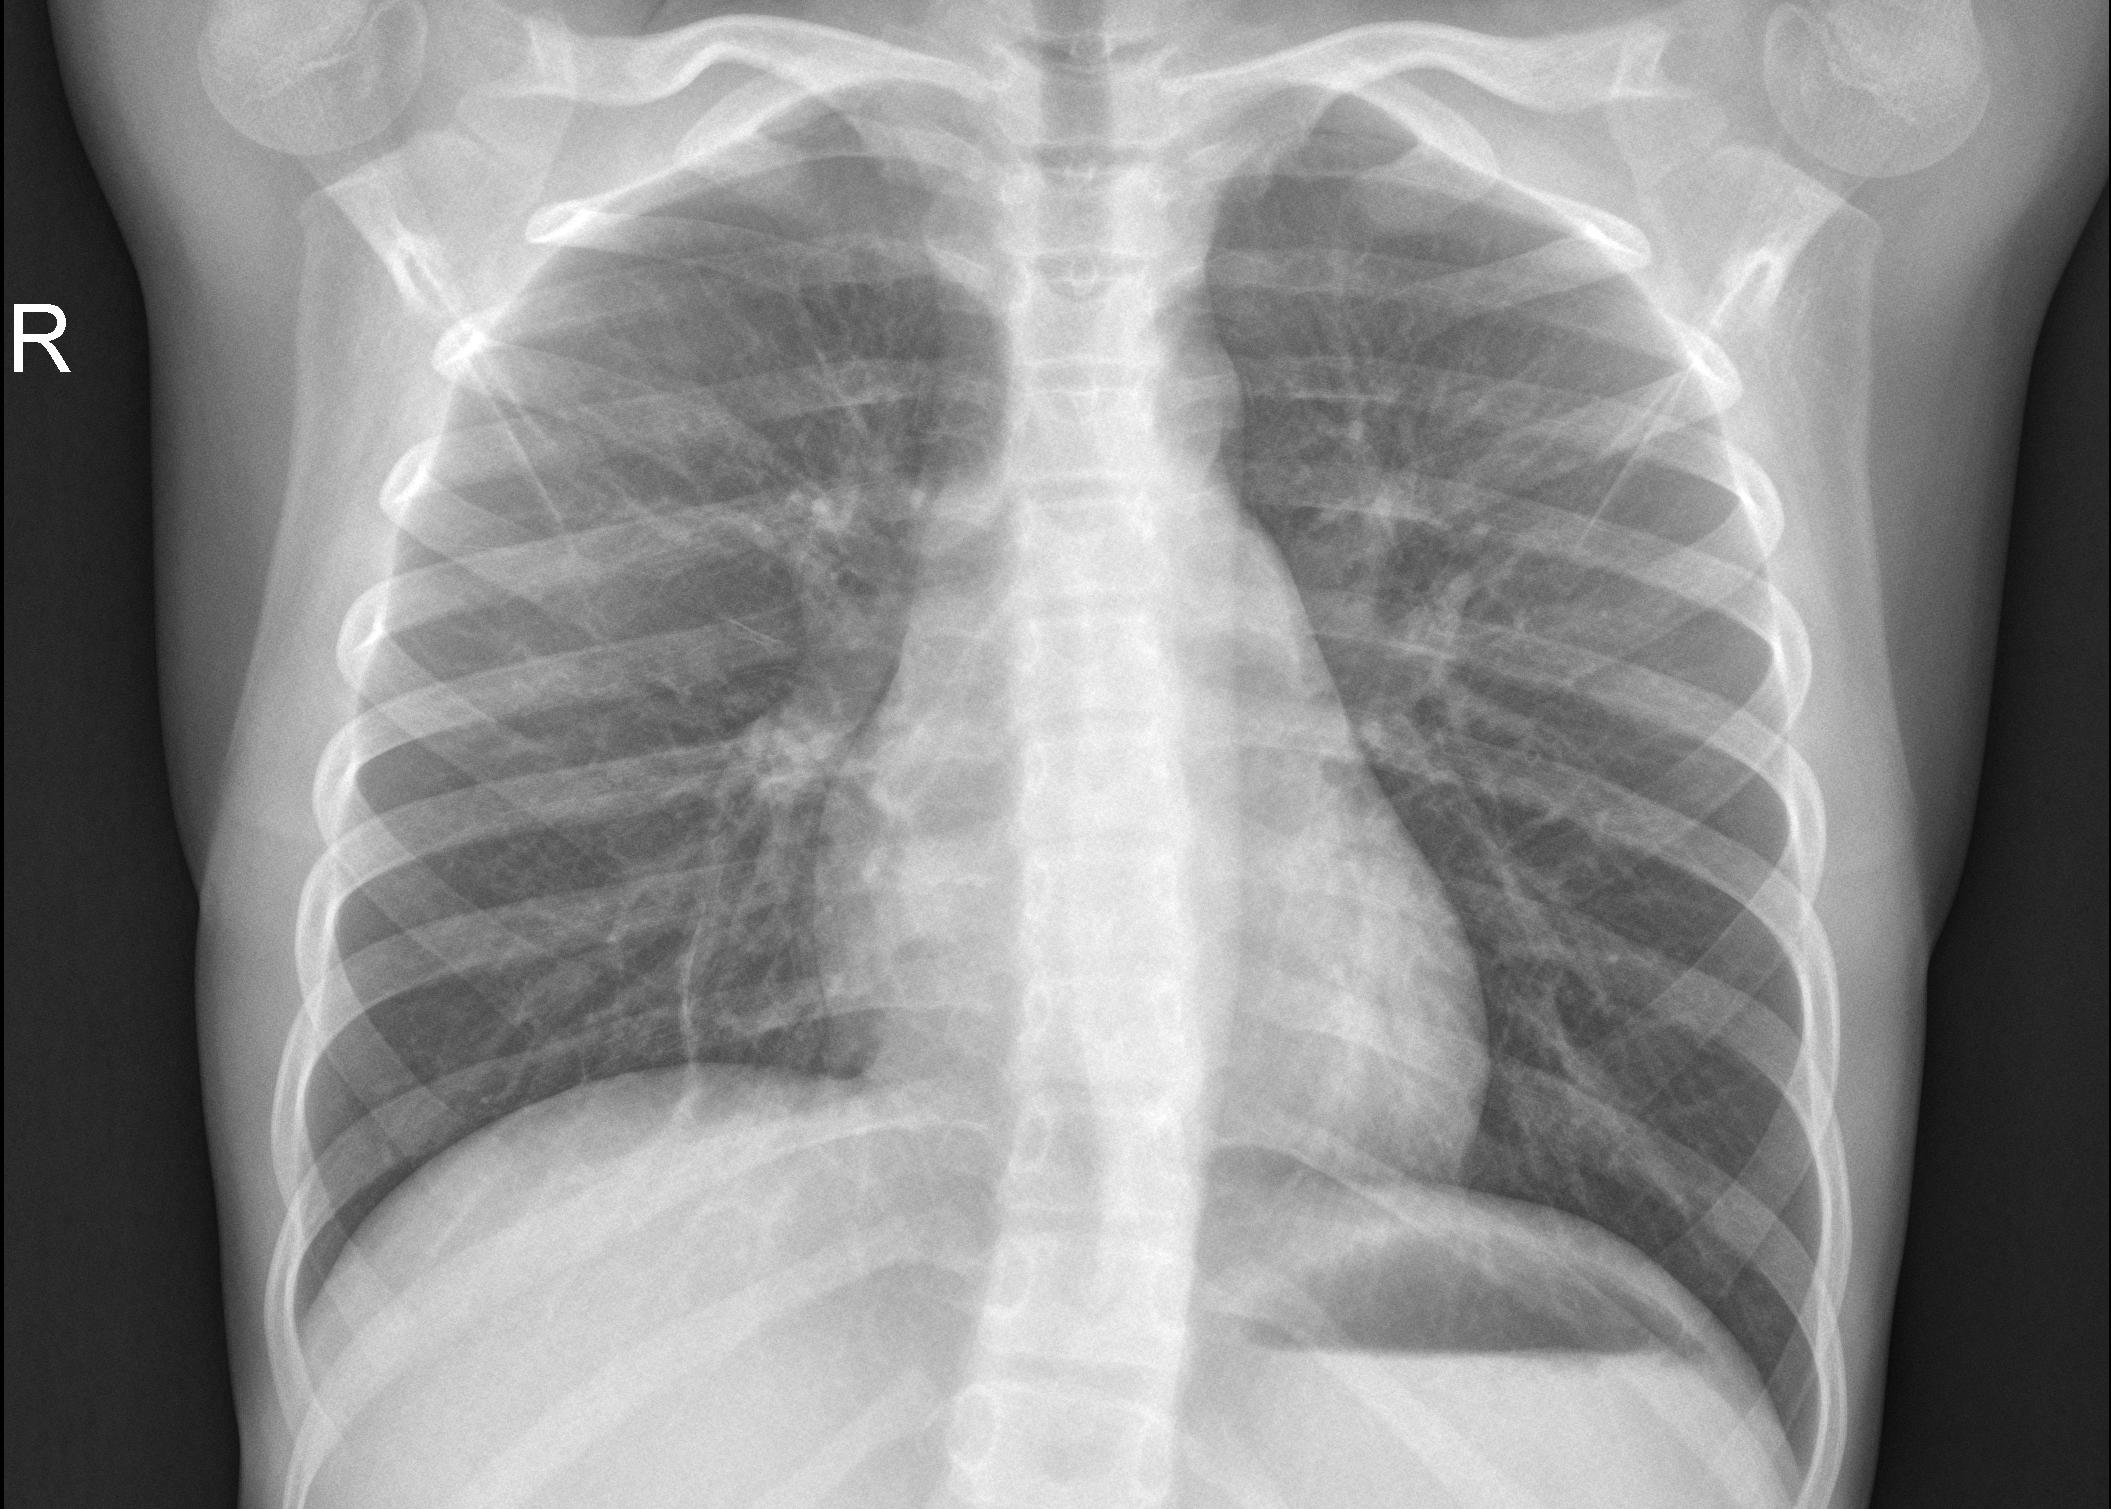

In [93]:
Image('./chest_xray/chest_xray/test/NORMAL/IM-0003-0001.jpeg',width=800)

In [97]:
img_path = './chest_xray/chest_xray/test/NORMAL/IM-0003-0001.jpeg'
img = image.load_img(img_path, target_size=(299, 299))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
# x = preprocess_input(x)
print('Input image shape:', x.shape)

Input image shape: (1, 299, 299, 3)


In [98]:
pred = model.predict(x)
print('Predicted:', pred)

print(np.argmax(pred))

Predicted: [[0.9499285  0.05007144]]
0


In [99]:
result= np.argmax(pred)
if result==0:
    print("Normal")
elif result==1:
    print("Pneumonia Detected ")


Normal


The model has correctly predicted that this chest-xray is normal.

## Saving the model and weights back to local machine

In [100]:
# Downloading from colab to local machine

from google.colab import files

files.download('pneumoniadetection.h5')  

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Conclusion

As seen above, our model is reasonably accurate in predicting whether a chest-ray is positive for pneumonia or not, based on its test accuracy of about 93.9%.
Possible further improvements can be adding more test data for NORMAL chest-xrays, image augmentation which may enable the model to generalise better.
Other CNN architectures such as ResNet could be explored to see if models based on them give a better accuracy.

Future improvements that can be made to this project include deploying this model onto a web app, to enable potential users to upload chest x ray images and get predictions on whether pneumonia is detected or not.